<a href="https://colab.research.google.com/github/someshjaishwal/image-segmentation/blob/master/WNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [0]:
from IPython.display import clear_output as clear
import glob
import os
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

#
# pytorch specific
#

import torch
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchsummary import summary

from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# Mount Drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')

gdrive = '/gdrive/My\ Drive/'
clear()

In [0]:
!tar -xf $gdrive/dataset/IITK_Dataset.tar.gz

# Image Segmentation

## Dataset 

Build dataset , set transforms, split dataset -> training set, validation set


In [0]:
#
# Dataset
#

dataset_folder = './Dataset'
input_size = 224
b_size = 4
val_train_ratio = 0.9

composed_transform = transforms.Compose([transforms.Scale((input_size,input_size)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])

dataset = torchvision.datasets.ImageFolder(dataset_folder, transform = composed_transform)
val_len = int(val_train_ratio * len(dataset))
train_len = len(dataset) - val_len

training_set, val_set = torch.utils.data.random_split(dataset, [train_len, val_len])

data_loader = torch.utils.data.DataLoader(training_set,
                                          batch_size = b_size,
                                          shuffle = True,
                                          num_workers = 4)
val_loader = torch.utils.data.DataLoader(val_set,
                                          batch_size = b_size,
                                          shuffle = True,
                                          num_workers = 4)

clear()

## Model

Model build : [W-Net](https://arxiv.org/pdf/1711.08506.pdf)

> > > > > > 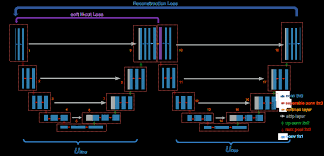


> > > > > > > >   Model Architecture

### Block 

A **block** describes a module mentioned in paper https://arxiv.org/pdf/1711.08506.pdf

In [0]:
class Block(nn.Module):
    def __init__(self, in_filters, out_filters, seperable=True):
        
        # in_filters = number of input channel
        # out_filters = number of output channel
        # seperable denotes if need depth separable conv layer
        
        super(Block, self).__init__()
        
        # depth separable blocks except : 1, 9, 10, 18
        if seperable:
            
            self.spatial1=nn.Conv2d(in_filters, in_filters, kernel_size=3, groups=in_filters, padding=1)
            self.depth1=nn.Conv2d(in_filters, out_filters, kernel_size=1)
            
            self.conv1=lambda x: self.depth1(self.spatial1(x))
            
            self.spatial2=nn.Conv2d(out_filters, out_filters, kernel_size=3, padding=1, groups=out_filters)
            self.depth2=nn.Conv2d(out_filters, out_filters, kernel_size=1)
            
            self.conv2=lambda x: self.depth2(self.spatial2(x))
            
        # non-seperable blocks 1, 9, 10, 18
        else:
            
            self.conv1=nn.Conv2d(in_filters, out_filters, kernel_size=3, padding=1)
            self.conv2=nn.Conv2d(out_filters, out_filters, kernel_size=3, padding=1)
        
        self.batchnorm1=nn.BatchNorm2d(out_filters)
        self.batchnorm2=nn.BatchNorm2d(out_filters)

    def forward(self, x):
        
        # operations
        x=self.batchnorm1(self.conv1(x)).clamp(0)
        
        x=self.batchnorm2(self.conv2(x)).clamp(0)
        
        return x

### Encoder

**UEnc** implements the encoder part (described [here](https://arxiv.org/pdf/1711.08506.pdf)) of W-Net 

forward(...) method implements the flow of encoder

In [0]:
class UEnc(nn.Module):
    def __init__(self, squeeze, ch_mul=64, in_chans=3):
        
        # squeeze : denotes number of channels in final layer of encoder
        # in_chans : number of input channel
        # ch_mul : base number of output channel 
        
        super(UEnc, self).__init__()
        
        # left half
        self.enc1=Block(in_chans, ch_mul, seperable=False)
        self.enc2=Block(ch_mul, 2*ch_mul)
        self.enc3=Block(2*ch_mul, 4*ch_mul)
        self.enc4=Block(4*ch_mul, 8*ch_mul)
        
        # middle
        self.middle=Block(8*ch_mul, 16*ch_mul)
        
        # right half
        self.up1=nn.ConvTranspose2d(16*ch_mul, 8*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec1=Block(16*ch_mul, 8*ch_mul)
        self.up2=nn.ConvTranspose2d(8*ch_mul, 4*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2=Block(8*ch_mul, 4*ch_mul)
        self.up3=nn.ConvTranspose2d(4*ch_mul, 2*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec3=Block(4*ch_mul, 2*ch_mul)
        self.up4=nn.ConvTranspose2d(2*ch_mul, ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec4=Block(2*ch_mul, ch_mul, seperable=False)
        
        # final layer
        self.final=nn.Conv2d(ch_mul, squeeze, kernel_size=(1, 1))
        
    def forward(self, x):
        
        # left half operations
        enc1=self.enc1(x)
        
        enc2=self.enc2(F.max_pool2d(enc1, (2, 2)))
        
        enc3=self.enc3(F.max_pool2d(enc2, (2,2)))
        
        enc4=self.enc4(F.max_pool2d(enc3, (2,2)))
        
        # middle layer
        middle=self.middle(F.max_pool2d(enc4, (2,2)))
        
        # right half operations in encoder
        up1=torch.cat([enc4, self.up1(middle)], 1)
        dec1=self.dec1(up1)
        
        up2=torch.cat([enc3, self.up2(dec1)], 1)
        dec2=self.dec2(up2)
        
        up3=torch.cat([enc2, self.up3(dec2)], 1)
        dec3=self.dec3(up3)
        
        up4=torch.cat([enc1, self.up4(dec3)], 1)
        dec4=self.dec4(up4)
        
        
        final=self.final(dec4)
        
        return final


### Decoder


**UDec** implements the decoder part (described [here](https://arxiv.org/pdf/1711.08506.pdf)) of W-Net 

forward(...) method implements the flow of decoder

In [0]:
class UDec(nn.Module):
    def __init__(self, squeeze, ch_mul=64, in_chans=3):
        
                
        # squeeze : denotes number of channels in final layer of encoder
        # in_chans : number of input channel
        # ch_mul : base number of output channel 
        
        super(UDec, self).__init__()
        
        # left half
        self.enc1=Block(squeeze, ch_mul, seperable=False)
        self.enc2=Block(ch_mul, 2*ch_mul)
        self.enc3=Block(2*ch_mul, 4*ch_mul)
        self.enc4=Block(4*ch_mul, 8*ch_mul)
        
        # middle
        self.middle=Block(8*ch_mul, 16*ch_mul)
        
        # right half
        self.up1=nn.ConvTranspose2d(16*ch_mul, 8*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec1=Block(16*ch_mul, 8*ch_mul)
        self.up2=nn.ConvTranspose2d(8*ch_mul, 4*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2=Block(8*ch_mul, 4*ch_mul)
        self.up3=nn.ConvTranspose2d(4*ch_mul, 2*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec3=Block(4*ch_mul, 2*ch_mul)
        self.up4=nn.ConvTranspose2d(2*ch_mul, ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec4=Block(2*ch_mul, ch_mul, seperable=False)
        
        self.final=nn.Conv2d(ch_mul, in_chans, kernel_size=(1, 1))
        
    def forward(self, x):
        
        # left half operations
        enc1 = self.enc1(x)
        
        enc2 = self.enc2(F.max_pool2d(enc1, (2, 2)))
        
        enc3 = self.enc3(F.max_pool2d(enc2, (2,2)))
        
        enc4 = self.enc4(F.max_pool2d(enc3, (2,2)))
        
        # middle layer operations
        middle = self.middle(F.max_pool2d(enc4, (2,2)))
        
        # right layer operations
        up1 = torch.cat([enc4, self.up1(middle)], 1)
        dec1 = self.dec1(up1)
        
        up2 = torch.cat([enc3, self.up2(dec1)], 1)
        dec2 = self.dec2(up2)
        
        up3 = torch.cat([enc2, self.up3(dec2)], 1)
        dec3 =self.dec3(up3)
        
        up4 = torch.cat([enc1, self.up4(dec3)], 1)
        dec4 = self.dec4(up4)
        
        # final o/p of decoder
        final=self.final(dec4)
        
        return final


### W-Net

**WNet** implements W-Net 

forward(...) method stitches encoder and decoder (described [here](https://arxiv.org/pdf/1711.08506.pdf))

In [0]:
class WNet(nn.Module):
    def __init__(self, squeeze, ch_mul=64, in_chans=3, out_chans=1000):
        
        # squeeze : denotes number of channels in final layer of encoder
        # in_chans : number of input channel
        # ch_mul : base number of output channel 
        
        super(WNet, self).__init__()
        if out_chans==1000:
            out_chans=in_chans
        self.UEnc=UEnc(squeeze, ch_mul, in_chans)
        self.UDec=UDec(squeeze, ch_mul, out_chans)
        
    def forward(self, x, bypass_enc = False,  returns='both'):
        
        # bypasses the encoding, x needed to be already encoded
        if bypass_enc:
            return self.UDec(F.softmax(x, 1))
        
        # encoder
        enc = self.UEnc(x)
        
        if returns=='enc':
            return enc
        
        # decoder
        dec = self.UDec(F.softmax(enc, 1))
        
        if returns=='dec':
            return dec
        
        # return both
        if returns=='both':
            return enc, dec
        
        else:
            raise ValueError('Invalid returns, returns must be in [enc dec both]')

In [0]:
# create WNet model for 4 clusters
model = WNet(4).cuda()

## Training Model

Describes loss functions, optimizer, training phase, save and load associated with model

### Loss functions

In [0]:
# vertical_sobel :  to help get edges in vertical direction
vertical_sobel = torch.nn.Parameter(torch.from_numpy(np.array([[[[1,  0,  -1], 
                                            [1,  0,  -1], 
                                            [1,  0,  -1]]]])).float().cuda(), requires_grad=False)

# horizontal_sobel :  to help get edges in horizontal direction
horizontal_sobel = torch.nn.Parameter(torch.from_numpy(np.array([[[[1,   1,  1], 
                                              [0,   0,  0], 
                                              [-1 ,-1, -1]]]])).float().cuda(), requires_grad=False)

In [0]:
# softncut loss : loss function for encoder
def softncut(softmax, device='cuda'):

    vert=torch.cat([F.conv2d(softmax[:, i].unsqueeze(1), vertical_sobel) for i in range(softmax.shape[1])], 1)
    hori=torch.cat([F.conv2d(softmax[:, i].unsqueeze(1), horizontal_sobel) for i in range(softmax.shape[1])], 1)
    mag = torch.pow(torch.pow(vert, 2)+torch.pow(hori, 2), 0.5)
    mean=torch.mean(mag)
    return mean


### Optimizer

In [0]:
# parameter for optimizer
learning_rate =  0.1
hyp_momentum = 0.9

# sgd optimimzer
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

### Training Phase

Training model **WNet** :

* train_snc(...) method trains model considering soft normalized cut loss on encoding as well as reconstruction loss on image reconstruction 

* train_naive(...) method trains model considering only reconstruction loss

In [0]:
def train_snc(model, optimizer, data_loader, epochs, device, psi=0.5):
    
   # epochs
    for epoch in range(epochs):
        
        # keep track of training and validation loss each epoch
        softncut_loss = 0.0
        recons_loss = 0.0

        # Set to training and start timer
        model.train()
        
        for ii, (batch, labels) in enumerate(data_loader):
            batch, labels = batch.to(device), labels.to(device)
     
            # clear grads
            optimizer.zero_grad()
            
            #------ train encoder ---------

            enc = model(batch, returns ='enc')
            
            # loss
            n_cut_loss = softncut(enc) * psi
            n_cut_loss.backward(retain_graph=True)
            
            
            #------ train decoder ---------
            
            dec = model(enc, bypass_enc = True,  returns ='dec')
            
            # loss
            rec_loss = torch.mean(torch.pow(torch.pow(batch, 2) + torch.pow(dec, 2), 0.5))*(1-psi)
            rec_loss.backward()
            
            # optim for encoder and decoder
            optimizer.step()

            # train loss
            softncut_loss += n_cut_loss.item() * batch.size(0)
            recons_loss += rec_loss.item() * batch.size(0)
            
        softncut_loss /= len(data_loader.dataset)
        recons_loss /= len(data_loader.dataset)
        
        # free gpu meomory
        torch.cuda.empty_cache()
            
        print('Epoch ', epoch+1, ' : Soft Norm-Cut Loss =  ,', softncut_loss,' Reconstruction Loss =  ',recons_loss)
    return model

In [0]:
def train_naive(model, optimizer, data_loader, epochs, device, psi=0.5):
    
   # epochs
    for epoch in range(epochs):
        
        # keep track of training and validation loss each epoch
        softncut_loss = 0.0
        recons_loss = 0.0

        # Set to training and start timer
        model.train()
        
        for ii, (batch, labels) in enumerate(data_loader):
            batch, labels = batch.to(device), labels.to(device)
     
            # clear grads
            optimizer.zero_grad()

            dec = model(batch, returns ='dec')
            
            # loss
            rec_loss = torch.mean(torch.pow(torch.pow(batch, 2) + torch.pow(dec, 2), 0.5))*(1-psi)
            rec_loss.backward()
            
            # optim
            optimizer.step()

            # train loss
            #softncut_loss += n_cut_loss.item() * batch.size(0)
            recons_loss += rec_loss.item() * batch.size(0)
            
        #softncut_loss /= len(data_loader.dataset)
        recons_loss /= len(data_loader.dataset)
        
        # free gpu meomory
        torch.cuda.empty_cache()
        
        print('Epoch ', epoch+1, ': Reconstruction Loss =  ',recons_loss)
    return model

In [0]:
# invoke training
model = train_naive(model, optimizer, data_loader, epochs = 3, device = 'cuda')

Epoch  1 : Reconstruction Loss =   0.35648825281504454
Epoch  2 : Reconstruction Loss =   0.3556443603042615
Epoch  3 : Reconstruction Loss =   0.3554880491803201


### Save Model

Save model of not saved.


In [0]:
path = '/gdrive/My Drive/files/wnet_final.mdl' 

saved = 1
if not saved:
    torch.save(model.state_dict(), path)

### Load Model

Load model if want to !

In [0]:
path = '/gdrive/My Drive/files/wnet_soft_n_cut.mdl'

model = WNet(4).cuda()
model.load_state_dict(torch.load(path))

In [0]:
# model summary
summary(model.UEnc, (3, 224, 224))

## Curated W-*Net*

This part attempts to implement **fine tuning** on encoding part of **WNet**. The attempt basically tries to improve context capturization part of **WNet**. Its freezes localization part ( fsecond half of encoder) of an already trained model for some epochs, then trains again for few more iterations. Hope is that, as the model now trains on first half of encoder, it should improve its context capture capability.

In [0]:
# freezed first half of encoder (WNet architecture)

for i, (name, child) in enumerate(model.UEnc.named_children()):
    if i<5 :
        continue
    for param in child.parameters():
        param.requires_grad = False
    

In [0]:
# check layers if they're freezed

for name, child in model.UEnc.named_children():
    print('----------------',name,'----------------------------------')
    for param in child.parameters():
        print(param.requires_grad)

In [0]:
# re-invoke training
model = train_naive(model, optimizer, data_loader, epochs = 10, device = 'cuda')

Epoch  1 : Reconstruction Loss =   0.35530873908277116
Epoch  2 : Reconstruction Loss =   0.3553096251636983
Epoch  3 : Reconstruction Loss =   0.3553069487429354
Epoch  4 : Reconstruction Loss =   0.35530743055512015
Epoch  5 : Reconstruction Loss =   0.3553068891382906
Epoch  6 : Reconstruction Loss =   0.35530922577430885
Epoch  7 : Reconstruction Loss =   0.35530831649253686
Epoch  8 : Reconstruction Loss =   0.3553059563208162
Epoch  9 : Reconstruction Loss =   0.35530701227019723
Epoch  10 : Reconstruction Loss =   0.35530812940283724


## Prediction

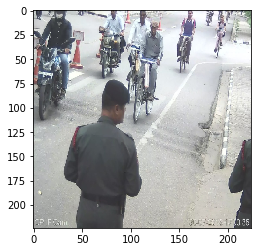

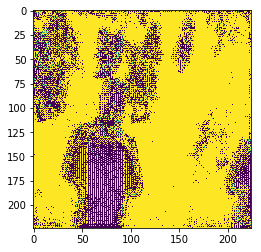

--------------------- Next Image ----------------


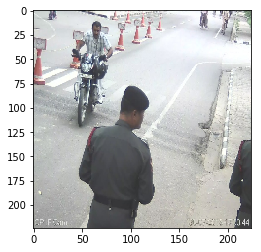

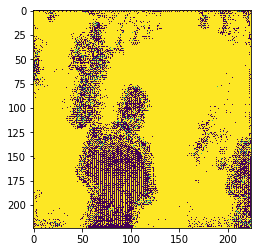

--------------------- Next Image ----------------


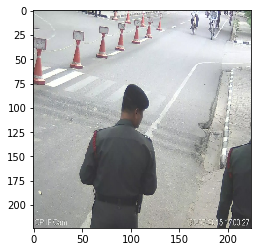

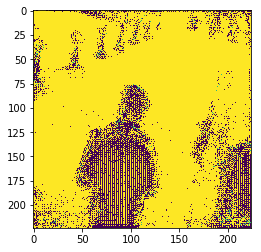

--------------------- Next Image ----------------


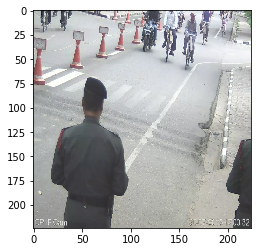

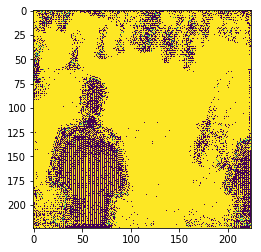

--------------------- Next Image ----------------


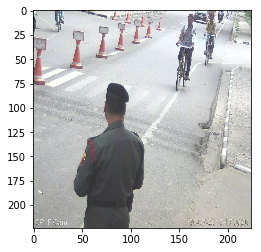

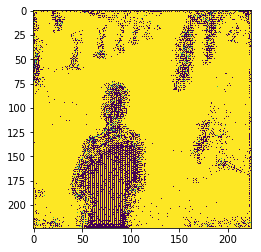

--------------------- Next Image ----------------


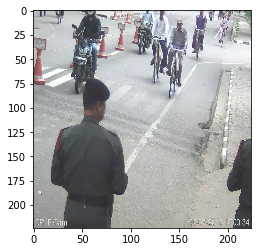

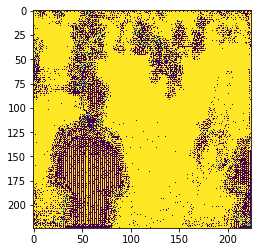

--------------------- Next Image ----------------


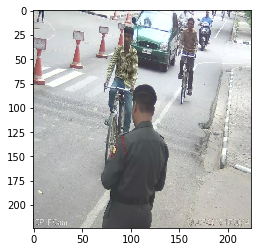

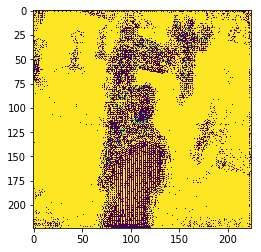

--------------------- Next Image ----------------


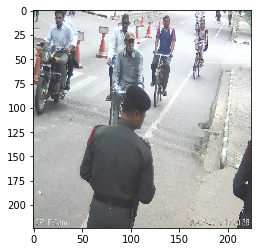

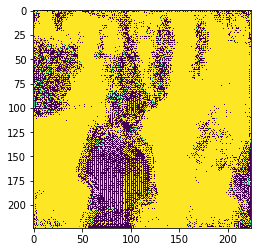

--------------------- Next Image ----------------


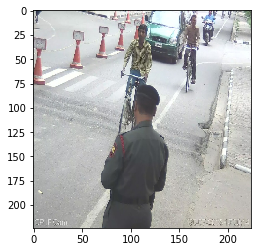

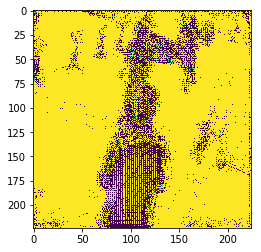

--------------------- Next Image ----------------


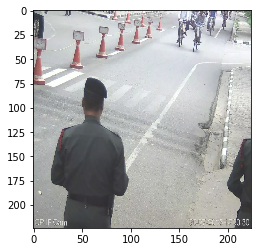

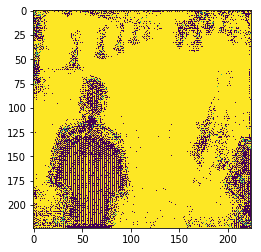

--------------------- Next Image ----------------


In [0]:
model.eval()
images_path = '/content/Dataset/camera4/JPEGImages/'

for img_path in glob.glob(images_path + '*.jpg')[:10]: 
    image = cv2.imread(img_path) 
    image = cv2.resize(image,(224,224))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    # show img
    plt.imshow(image)
    plt.show()
    
    trans_img = composed_transform(Image.fromarray(image)).cuda()
    trans_img = trans_img.unsqueeze(0)

    # predict segments
    segments = model(trans_img, returns ='enc')

    # get segment type
    _, segment_type = torch.max(segments, dim = 1)
    segments = segment_type.squeeze(0).cpu().numpy()
    
    # show segments
    plt.imshow(segments)
    plt.show()
    print('--------------------- Next Image ----------------')

    

In [0]:
!md5sum /gdrive/My\ Drive/files/wnet_final.mdl

5cdf23748214a69632623d84b9a677be  /gdrive/My Drive/files/wnet_final.mdl
